# ATMO656A Spring 2024 - Homework 7 (Mie Scattering for size distribution function)

Edgardo I. Sepulveda Araya

PyMieScatt package is used to compute mie scattering

Importing libraries:

In [118]:
import numpy as np
import pandas as pd
import time
from scipy.special import jv, yv
from scipy.integrate import trapz
from scipy import stats          #needed for lognormal distribution
import warnings
import PyMieScatt as pms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
# My favorite colors for figures:
custom_colors = [(6/255, 33/255, 92/255), (176/255, 35/255, 24/255),
                 (229/255, 179/255, 69/255), (131/255, 170/255, 69/255),
                 (116/255, 24/255, 123/255), (202/255, 91/255, 46/255),
                 (107/255, 188/255, 233/255), 'grey', 'black'] 

Modified functions (from original functions incorporated in PyMieScatt):

Integral is modified from coefficient $\beta$:

$$\beta = 10^{-6}\int_{0}^{\infty} \frac{\pi d_{p}^{2}}{4}Q(m,\lambda,d_{p})n(d_p)dd_p$$

to efficiency $\overline{Q}$:

$$\overline{Q} = \int_{0}^{\infty} Q(m,\lambda,d_{p})n(d_p)dd_p$$

In [9]:
def coerceDType(d):
    if type(d) is not np.ndarray:
        return np.array(d)
    else:
        return d

In [19]:
def Mie_SD_mod(m, wavelength, dp, ndp, nMedium=1.0, interpolate=False, asDict=False):
    nMedium = nMedium.real
    m /= nMedium
    wavelength /= nMedium
    dp = coerceDType(dp)
    ndp = coerceDType(ndp)
    _length = np.size(dp)
    Q_ext = np.zeros(_length)
    Q_sca = np.zeros(_length)
    Q_abs = np.zeros(_length)
    Q_pr = np.zeros(_length)
    Q_back = np.zeros(_length)
    Q_ratio = np.zeros(_length)
    g = np.zeros(_length)

    # MODIFIED LINE from "scaling of 1e-6 to cast in units of inverse megameters - see docs"
    aSDn = ndp # Original: np.pi*((dp/2)**2)*ndp
    #  _logdp = np.log10(dp)

    for i in range(_length):
        Q_ext[i], Q_sca[i], Q_abs[i], g[i], Q_pr[i], Q_back[i], Q_ratio[i] = pms.MieQ(m,wavelength,dp[i],nMedium)

    Qextt = trapz(Q_ext*aSDn)#,dp)
    Qscat = trapz(Q_sca*aSDn)#,dp)
    Qabst = Qextt-Qscatt
    Qbackt = trapz(Q_back*aSDn)#,dp)
    Qratiot = trapz(Q_ratio*aSDn)#,dp)
    #bigG = trapz(g*Q_sca*aSDn,dp)/trapz(Q_sca*aSDn,dp)
    bigGt = trapz(g*Q_sca*aSDn)/trapz(Q_sca*aSDn)
    Qprt = Qextt - bigGt*Qscat

    if asDict:
        return dict(Qextt=Qextt, Qscat=Qscat, Qabst=Qabst, Gt=bigGt, Qprt=Qprt, Qbackt=Qbackt, Qratiot=Qratiot)
    else:
        return Qextt, Qscat, Qabst, bigGt, Qprt, Qbackt, Qratiot

In [17]:
def Mie_Lognormal_mod(m,wavelength,geoStdDev,geoMean,numberOfParticles,nMedium=1.0, numberOfBins=10000,lower=1,upper=1000,gamma=[1],returnDistribution=False,decomposeMultimodal=False,asDict=False):
    nMedium = nMedium.real
    m /= nMedium
    wavelength /= nMedium
    ithPart = lambda gammai, dp, dpgi, sigmagi: (gammai/(np.sqrt(2*np.pi)*np.log(sigmagi)*dp))*np.exp(-(np.log(dp)-np.log(dpgi))**2/(2*np.log(sigmagi)**2))
    dp = np.logspace(np.log10(lower),np.log10(upper),numberOfBins)
    if all([type(x) in [list, tuple, np.ndarray] for x in [geoStdDev, geoMean]]):
        # multimodal
        if len(gamma)==1 and (len(geoStdDev)==len(geoMean)>1):
            # gamma is distributed equally among modes
            gamma = [1 for x in geoStdDev]
            gamma = [float(x/np.sum(gamma)) for x in gamma]
            ndpi = [numberOfParticles*ithPart(g,dp,dpg,sg) for g,dpg,sg in zip(gamma,geoMean,geoStdDev)]
            ndp = np.sum(ndpi,axis=0)
        elif len(gamma)==len(geoStdDev)==len(geoMean):
            # gamma is fully specified for each mode
            gamma = [float(x/np.sum(gamma)) for x in gamma]
            ndpi = [numberOfParticles*ithPart(g,dp,dpg,sg) for g,dpg,sg in zip(gamma,geoMean,geoStdDev)]
            ndp = np.sum(ndpi,axis=0)
        else:
            # user fucked up
            warnings.warn("Not enough parameters to fully specify each mode.")
            return None
    else:
        # unimodal
        decomposeMultimodal = False
        ndp = numberOfParticles*ithPart(1,dp,geoMean,geoStdDev)
    if ndp[-1]>np.max(ndp)/100 or ndp[0]>np.max(ndp)/100:
        warnings.warn("Warning: distribution may not be compact on the specified interval. Consider using a higher upper bound.")
    Qext, Qsca, Qabs, bigG, Qpr, Qback, Qratio = Mie_SD_mod(m,wavelength,dp,ndp)
    if returnDistribution:
        if decomposeMultimodal:
            if asDict==True:
                return dict(Qext=Qext, Qsca=Qsca, Qabs=Qabs, bigG=bigG, Qpr=Qpr, Qback=Qback, Qratio=Qratio), dp, ndp, ndpi
            else:
                return Qext, Qsca, Qabs, bigG, Qpr, Qback, Qratio, dp, ndp, ndpi
        else:
            if asDict==True:
                return dict(Qext=Qext, Qsca=Qsca, Qabs=Qabs, bigG=bigG, Qpr=Qpr, Qback=Qback, Qratio=Qratio), dp, ndp
            else:
                return Qext, Qsca, Qabs, bigG, Qpr, Qback, Qratio, dp, ndp
    else:
        if asDict==True:
            return dict(Qext=Qext, Qsca=Qsca, Qabs=Qabs, bigG=bigG, Qpr=Qpr, Qback=Qback, Qratio=Qratio)
        else:
            return Qext, Qsca, Qabs, bigG, Qpr, Qback, Qratio

## Q2, Q3 and Q4

In [105]:
m     = 1.3873 + 0.0066j          # Refractive Index
wl    = 500                       # wavelength in nm (unit requested by PyMieScatt)
gsd   = [1.1, 1.4, 1.8, 2.1, 2.5] # Geometric Standard Deviation of size distribution
gmean = np.arange(10,10010,10)     # Geometric mean of size distribution in nm (unit requested by PyMieScatt)
npart = 10000                     # Number of particles
nMedium = 1

In [106]:
Q_ext = []
for ri in gmean:
    result = pms.MieQ(m,wl,ri,nMedium)
    Q_ext.append(result[0])

In [107]:
x = 2*np.pi*gmean/wl

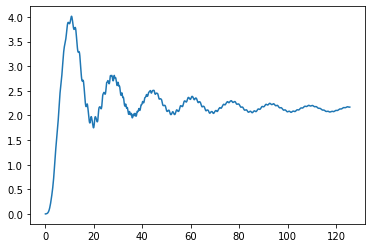

In [108]:
plt.plot(x,Q_ext)

It takes like one hour !!!:

In [111]:
r_space  = np.logspace(-1,6,100)
Q_ext_sd = np.zeros((len(gmean),len(gsd)))
for gsd_i in range(len(gsd)):
    start = time.time()
    for r_i in range(len(gmean)):
        start = time.time()
        lognorm = (1/(np.sqrt(2*np.pi)*np.log(gsd[gsd_i]))) * np.exp( -((np.log(r_space)-np.log(gmean[r_i]))**2)/(2*np.log(gsd[gsd_i])**2))
        nrqri   = []
        for logri in range(len(r_space)):
            mie_result = pms.MieQ(m, wl, r_space[logri], nMedium)
            nrqri.append(lognorm[logri]*mie_result[0])
        Q_ext_sd[r_i,gsd_i] = trapz(nrqri)
        if r_i in [20,40,60,80,100,500,999]: 
            print(gsd[gsd_i], gmean[r_i])
            end = time.time()
            print(end - start)

10000
0.5419979095458984
10000
0.5114829540252686
10000
0.4417860507965088
10000
0.8908629417419434
10000
0.4446408748626709
10000
0.6452112197875977
10000
0.5715477466583252
10000
0.6666696071624756
10000
0.9114091396331787
10000
0.8073139190673828
10000
0.8078458309173584
10000
0.6052050590515137
10000
0.3624451160430908
10000
0.4201240539550781
10000
0.4231269359588623
10000
0.5532360076904297
10000
0.5686728954315186
10000
0.5250911712646484
10000
0.46071290969848633
10000
0.4410560131072998
10000
0.5028207302093506
10000
0.4707179069519043
10000
0.9967460632324219
10000
1.4072139263153076
10000
0.452678918838501
10000
0.884127140045166
10000
0.4303288459777832
10000
0.6512298583984375
10000
0.4143180847167969
10000
0.6650879383087158
10000
0.5484180450439453
10000
0.4179520606994629
10000
0.6639499664306641
10000
0.3765280246734619
10000
0.3305962085723877


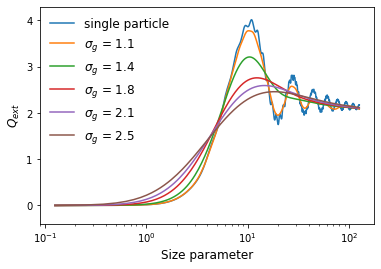

In [133]:
magic_factor = 0.16 # Why??
Q_ext_sd_scaled = Q_ext_sd*magic_factor

plt.plot(x, Q_ext, label = 'single particle', linewidth = 1.5)
plt.plot(x, Q_ext_sd_scaled[:,0], label = r'$\sigma_g$ = 1.1', linewidth = 1.5)
plt.plot(x, Q_ext_sd_scaled[:,1], label = r'$\sigma_g$ = 1.4', linewidth = 1.5)
plt.plot(x, Q_ext_sd_scaled[:,2], label = r'$\sigma_g$ = 1.8', linewidth = 1.5)
plt.plot(x, Q_ext_sd_scaled[:,3], label = r'$\sigma_g$ = 2.1', linewidth = 1.5)
plt.plot(x, Q_ext_sd_scaled[:,4], label = r'$\sigma_g$ = 2.5', linewidth = 1.5)

plt.ylabel(r'$Q_{ext}$', fontsize = 12)
plt.xlabel('Size parameter', fontsize = 12)

plt.xscale('log')

plt.ylim(-0.4, 4.3)

plt.legend(frameon = False, ncol = 1, fontsize = 12, loc='upper left')

Saving data (avoid running the calculation again):

In [130]:
# convert array into dataframe 
DF = pd.DataFrame(Q_ext_sd_scaled) 
  
# save the dataframe as a csv file 
DF.to_csv("Q_ext_sd.csv")